<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/gpax_viGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For github continuous integration
import os
if os.environ.get("CI_SMOKE"):
    SMOKE = True
else:
    SMOKE = False

# Sparse image reconstruction with GPax


*Prepared by Maxim Ziatdinov (May 2023). Last updated in February 2024.*

This notebook shows a simple example of how GPax can be utilized for sparse image reconstruction.

## Install & Import

Install the latest GPax package from PyPI (this is best practice, as it installs the latest, deployed and tested version).

In [2]:
!pip install -q gpax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.5/99.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.0/371.0 kB 14.1 MB/s eta 0:00:00


Import needed packages:

In [3]:
try:
    # For use on Google Colab
    import gpax

except ImportError:
    # For use locally (where you're using the local version of gpax)
    print("Assuming notebook is being run locally, attempting to import local gpax module")
    import sys
    sys.path.append("..")
    import gpax

In [4]:
import numpy as np
import matplotlib.pyplot as plt

Enable some pretty plotting.

In [5]:
import matplotlib as mpl

In [6]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = False
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 200

## viGP

Download sparse image data. This is a scanning probe microsocpy image obtained via a sparse spiral scanning. See [this paper](https://doi.org/10.1002/smll.202002878) for more details.

In [7]:
!wget -qq -O 'spiral_scans_2d.npy' 'https://github.com/ziatdinovmax/GPim/blob/master/expdata/spiral_s_00010_2019.npy?raw=true'

Visualize data:

In [8]:
imgdata = np.load('spiral_scans_2d.npy')

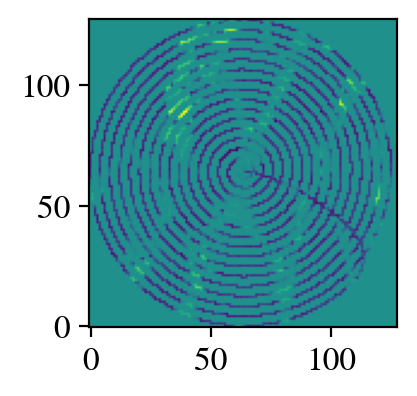

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.imshow(imgdata, origin='lower')
plt.show()

Normalize and assign zeros to regions with missing data values:

In [10]:
sparse_img = (imgdata - np.min(imgdata)) / np.ptp(imgdata)
sparse_img[sparse_img == sparse_img[1, 1]] = 0 # Take value at [1, 1] as missing data value

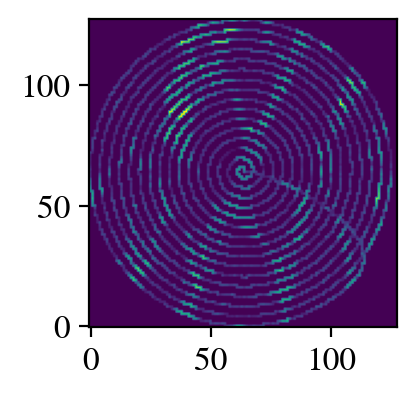

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.imshow(sparse_img, origin='lower')
plt.show()

Next, we prepare training inputs/targets for GP. Note that the missing data values must be represented by zeros. If you have actual data with elements whose values are zero, you will need to re-normalize it accordingly. Otherwise, those elements will be interpreted as mising values.

In [20]:
X_train, y_train, X_full = gpax.utils.preprocess_sparse_image(sparse_img)

Initilaize and train a variational inference GP model:

In [21]:
key1, key2 = gpax.utils.get_keys(1)

gp_model = gpax.viGP(input_dim=2, kernel='Matern', guide='delta')
gp_model.fit(key1, X_train, y_train, num_steps=250 if not SMOKE else 20, step_size=0.05)

100%|██████████| 250/250 [00:36<00:00,  6.79it/s, init loss: 4686.4609, avg. loss [229-240]: -4459.3301]



Inferred GP parameters
k_length         [4.1769    3.2482998]
k_scale          0.051599998
noise            0.0019999999


Use the trained to reconstruct the entire image (i.e., predict pixel values for a full set of pixel indices):

In [22]:
# We predict in batches to avoid memory overflow.
# The total size of X_full is 128*128=16384,so selecting the batch size of 1000 seems appropriate
f_pred, f_var = gp_model.predict_in_batches(key2, X_full, batch_size=1000)

Plot the results:

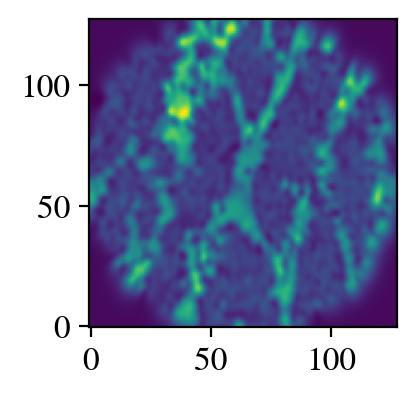

In [23]:
f_pred = f_pred.reshape(128, 128) # (height, width) of the original image

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.imshow(f_pred, origin='lower')
plt.show()

## Sparse viGP

For larger images or hyperspectral data, running viGP may be too slow and require too much memory. In those cases, an approximation based on [inducing inputs](https://www.jmlr.org/papers/volume6/quinonero-candela05a/quinonero-candela05a.pdf) may be used.

In [24]:
key1, key2 = gpax.utils.get_keys(1)

gp_model = gpax.viSparseGP(input_dim=2, kernel='Matern')

gp_model.fit(key1, X_train, y_train,  # standard training data
             inducing_points_ratio=0.3,  # inducing inputs / total inputs ratio
             num_steps=250 if not SMOKE else 20, step_size=0.05,  # standard training settings
             jitter=1e-5 # increase jitter for numerical stability
)

100%|██████████| 250/250 [00:12<00:00, 19.47it/s, init loss: 5055.7876, avg. loss [229-240]: -4182.4541]



Inferred GP parameters
k_length         [5.9667 4.4406]
k_scale          0.0592
noise            0.0034999999


In [25]:
f_pred, f_var = gp_model.predict_in_batches(key2, X_full, batch_size=1000)

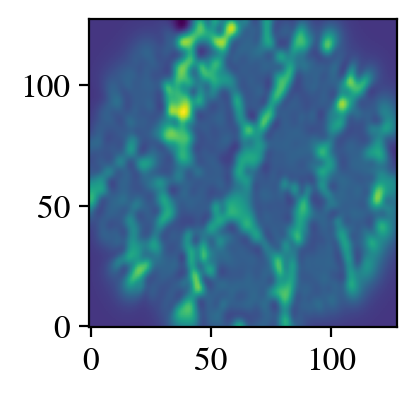

In [26]:
f_pred = f_pred.reshape(128, 128) # (height, width) of the original image

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.imshow(f_pred, origin='lower')
plt.show()

The model trained approximately 3 times faster and provided a reconstruction that captured the major features in the dataset, albeit with some finer details slightly blurred.

Note: if you experience convergence issues, such as *nan* values in training loss, try using different keys (pass a different value to ```get_keys```) for the training initialization. If that doesn't help, try switching to double precision by restarting the jupyter kernel and running ```gpax.utils.enable_x64()``` at the start of the notebook. Please also note that there is little advantge of using SparseGP when inducing_points_ratio > 0.5.